In [51]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xlrd as xd
import openpyxl
import datetime as dt
import seaborn as sns
import requests
import math
import warnings
from scipy import interpolate
import tabula
import matplotlib.dates as mdates
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression 
import xlsxwriter
import matplotlib.ticker as ticker
from scipy.interpolate import interp1d
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima.model import ARIMA
from arch import arch_model
from sklearn.metrics import r2_score



warnings.filterwarnings('ignore')

In [52]:
#Common filter

# Data

## Housing Prices
1970 to 2003 = https://appliedeconomics.com.au/wp-content/uploads/2021/10/2006-real-story-of-house-prices-australia-1970-2003.pdf \
2002 to 2021 = https://www.abs.gov.au/statistics/economy/price-indexes-and-inflation/residential-property-price-indexes-eight-capital-cities/latest-release#data-downloads \
2021 to 2023 = Domain @ https://www.domain.com.au/research/house-price-report

Note: used averages between the two data sources in 2002 and 2003 and Domain data sometimnes changes there past records so I worked my way backwards from their most recent

## Mortgage rates
Source = https://www.rba.gov.au/statistics/tables/#interest-rates <br />
Table1 = Interest Rates and Yields – Money Market – Monthly – F1.1, series = Cash Rate Target; monthly average, 3-month BABs/NCDs <br />

Table2 = Housing Lending Rates – , series = Lending rates; Housing credit; Outstanding; Owner-occupied; All loans; Large institution


# Visualising

In [53]:
prices = pd.read_csv('data/merged house prices.csv') #thanks to Peter Abelson, ABS, Domain
prices = prices.set_index(prices['Year'])
prices = prices.drop('Year', axis = 1)

In [54]:
#Mortgage rates
interestRates = pd.read_csv('data/long run 3 month TD.csv', parse_dates=['Date']) #thanks to RBA
interestRates = interestRates.set_index(interestRates['Date'])
interestRates = interestRates.drop('Date', axis = 1)
interestRates = interestRates[0:-1]

In [55]:
fund = pd.read_csv('data/Mortgage returns.csv', parse_dates=['Date'])

In [56]:
list = []
for i in fund.index:
    for j in range(3):
        list.append(fund.iloc[i,1])

list = list[::-1]

In [57]:
interestRates['mortgage fund'] = 0

In [58]:
count = 0
for i in interestRates.iloc[288:].index:
    try:
        interestRates.at[i, 'mortgage fund'] = list[count]
    except IndexError:
        print('end at:', i)
        break
    count += 1

end at: 2020-06-01 00:00:00


In [59]:
interestRates['mortgage fund'] = interestRates['mortgage fund'].replace(0, np.nan)

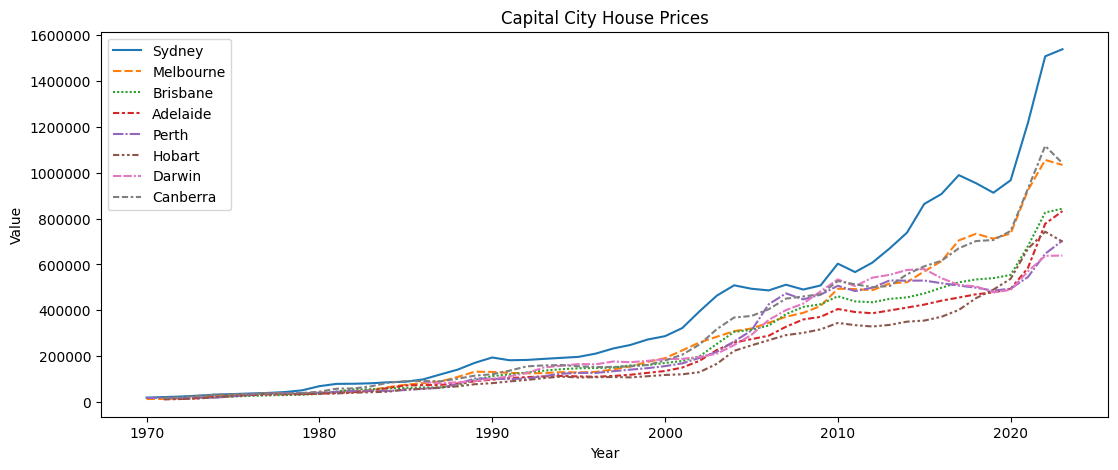

In [60]:
plt.figure(figsize = (13,5))
ax = sns.lineplot(data=prices)
plt.xlabel('Year')
plt.ylabel('Value')
plt.title('Capital City House Prices')
plt.ticklabel_format(style='plain', axis='y')

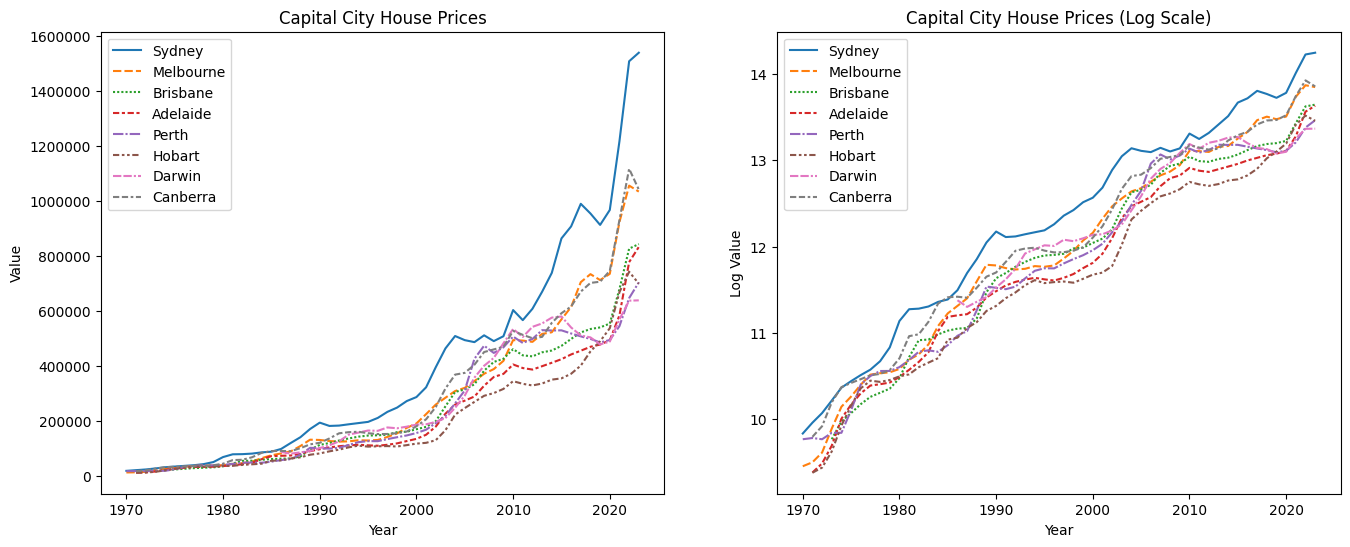

In [61]:
plt.figure(figsize = (16,6))
plt.subplot(1,2,1)
ax = sns.lineplot(data=prices)
plt.xlabel('Year')
plt.ylabel('Value')
plt.title('Capital City House Prices')
plt.ticklabel_format(style='plain', axis='y')
plt.subplot(1,2,2)
plt.subplot(1, 2, 2)
ax = sns.lineplot(data=prices.apply(np.log))  # apply logarithm to each value in the DataFrame
plt.xlabel('Year')
plt.ylabel('Log Value')
plt.title('Capital City House Prices (Log Scale)')
plt.ticklabel_format(style='plain', axis='y')

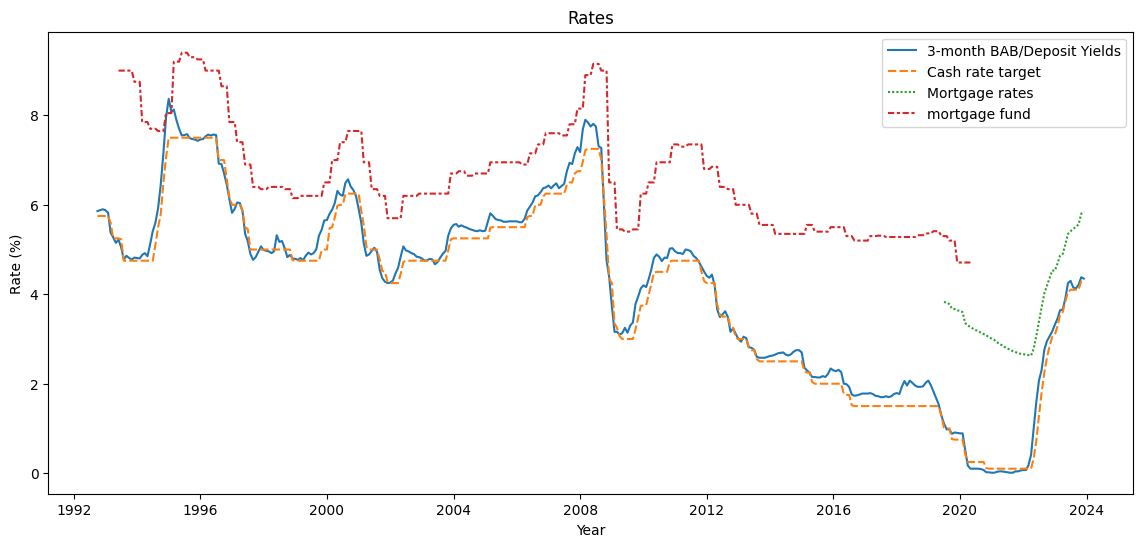

In [62]:
plt.figure(figsize = (14,6))
ax = sns.lineplot(data=interestRates.iloc[280:])
plt.xlabel('Year')
plt.ylabel('Rate (%)')
plt.title('Rates')
plt.ticklabel_format(style='plain', axis='y')

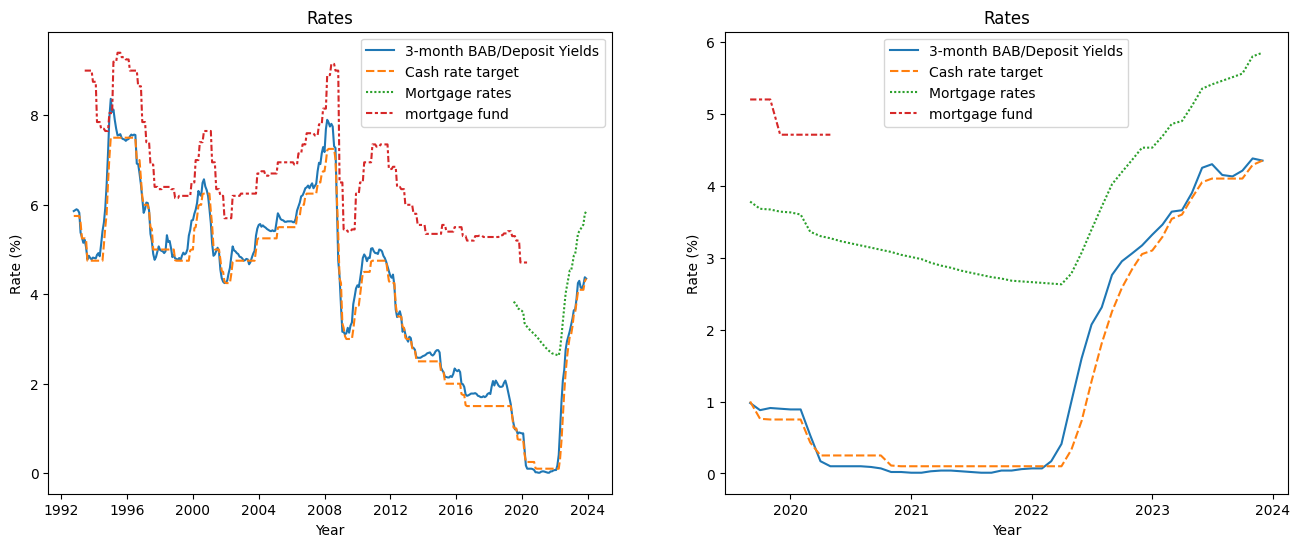

In [63]:
plt.figure(figsize = (16,6))
plt.subplot(1,2,1)
ax = sns.lineplot(data=interestRates.iloc[280:])
plt.xlabel('Year')
plt.ylabel('Rate (%)')
plt.title('Rates')
plt.ticklabel_format(style='plain', axis='y')
plt.subplot(1,2,2)
plt.xlabel('Year')
plt.ylabel('Rate (%)')
plt.title('Rates')
ax = sns.lineplot(data=interestRates.iloc[603:])
# Set x-axis ticks to display only years
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.show()

In [64]:
interestRates['avg mortgage'] = np.nan

In [65]:
for i in interestRates.iloc[288:].index:
    if pd.isna(interestRates['Mortgage rates'][i]):
        interestRates.at[i, 'avg mortgage'] = interestRates['mortgage fund'][i]
    else:
        interestRates.at[i, 'avg mortgage'] = interestRates['Mortgage rates'][i]

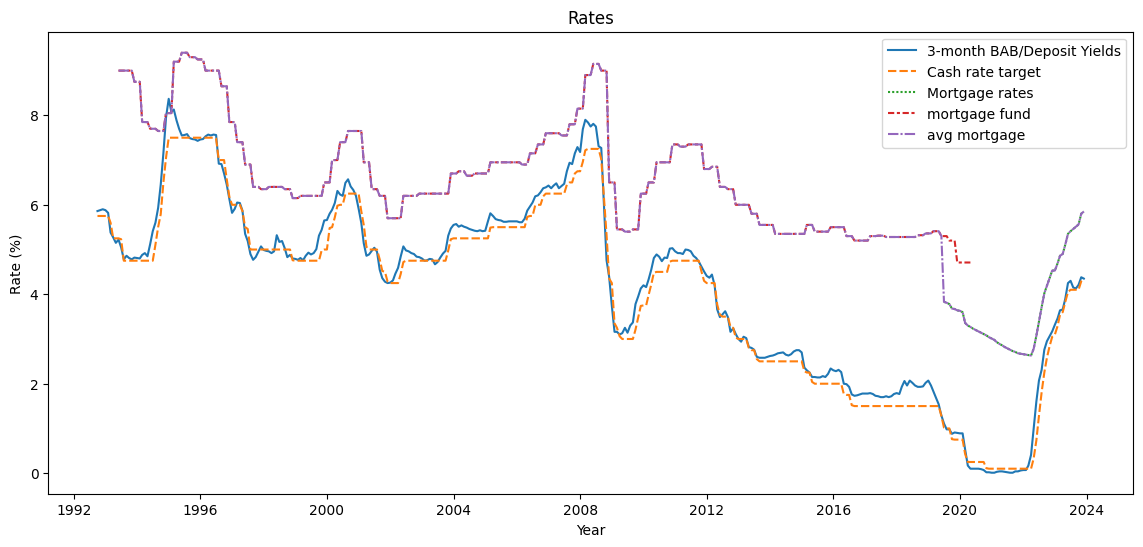

In [66]:
plt.figure(figsize = (14,6))
ax = sns.lineplot(data=interestRates.iloc[280:])
plt.xlabel('Year')
plt.ylabel('Rate (%)')
plt.title('Rates')
plt.ticklabel_format(style='plain', axis='y')

In [67]:
interestRates.iloc[288]

3-month BAB/Deposit Yields    5.22
Cash rate target              5.25
Mortgage rates                 NaN
mortgage fund                 9.00
avg mortgage                  9.00
Name: 1993-06-01 00:00:00, dtype: float64

In [68]:
#clearly there are some times where the deposit yields do go up quite a bit but by how much?
TDMinusCash = interestRates.iloc[256:,0] - interestRates.iloc[256:,1]
TDMinusCash.name = "3-month TD - cash rate target"
MortgageMinusTD = interestRates.iloc[603:,2] - interestRates.iloc[603:,0]
MortgageMinusTD.name = "mortgage rates - 3-month TD"
MortgageMinusCash = interestRates.iloc[603:,2] - interestRates.iloc[603:,1]
MortgageMinusCash.name = "mortgage rates - cash rate target"
differences = pd.DataFrame(data = [TDMinusCash, MortgageMinusTD, MortgageMinusCash]).T

In [69]:
#clearly there are some times where the deposit yields do go up quite a bit but by how much?
MortgageMinusTD = interestRates.iloc[288:,4] - interestRates.iloc[288:,0]
MortgageMinusTD.name = "Avg Mortgage Rates - 3-Month TD"

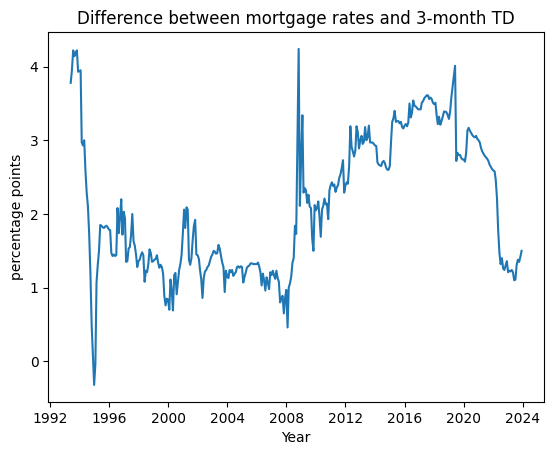

In [70]:
ax = sns.lineplot(data=(MortgageMinusTD))
plt.xlabel('Year')
plt.ylabel('percentage points')
plt.title('Difference between mortgage rates and 3-month TD')
plt.show()

In [71]:
lagRates = pd.DataFrame(interestRates['3-month BAB/Deposit Yields'])

In [72]:
for i in range(1,6):
    lagRates[f'value_lag_{i}'] = lagRates['3-month BAB/Deposit Yields'].shift(i)

In [73]:
lagRates

,3-month BAB/Deposit Yields,value_lag_1,value_lag_2,value_lag_3,value_lag_4,value_lag_5
Date,,,,,,
1969-06-01,5.90,NaN,NaN,NaN,NaN,NaN
1969-07-01,5.80,5.90,NaN,NaN,NaN,NaN
1969-08-01,6.10,5.80,5.90,NaN,NaN,NaN
1969-09-01,5.80,6.10,5.80,5.90,NaN,NaN
1969-10-01,5.60,5.80,6.10,5.80,5.90,NaN
...,...,...,...,...,...,...
2023-08-01,4.15,4.30,4.25,3.90,3.66,3.64
2023-09-01,4.13,4.15,4.30,4.25,3.90,3.66
2023-10-01,4.21,4.13,4.15,4.30,4.25,3.90


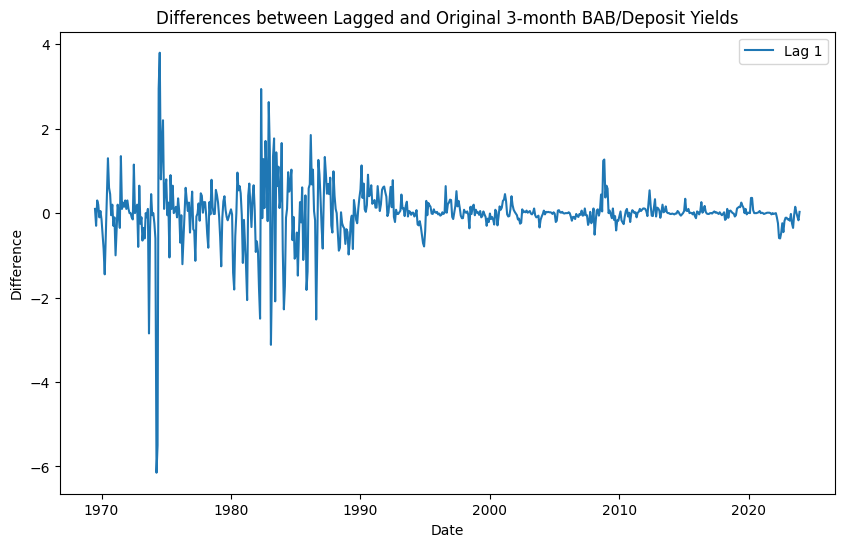

In [74]:
# Calculate differences
for i in range(1, 6):
    lagRates[f'difference_lag_{i}'] = lagRates[f'value_lag_{i}'] - lagRates['3-month BAB/Deposit Yields']

# Plot differences
plt.figure(figsize=(10, 6))
for i in range(1, 2):
    plt.plot(lagRates.index, lagRates[f'difference_lag_{i}'], label=f'Lag {i}')

plt.xlabel('Date')
plt.ylabel('Difference')
plt.title('Differences between Lagged and Original 3-month BAB/Deposit Yields')
plt.legend()
plt.show()

avg mortgage = B(mortgage rates - 3-month TD) + B(differences in lagged 3-month deposit yield)

In [75]:
lagRates['mortgage rates'] = interestRates['avg mortgage']

In [76]:
lagRates

,3-month BAB/Deposit Yields,value_lag_1,value_lag_2,value_lag_3,value_lag_4,value_lag_5,difference_lag_1,difference_lag_2,difference_lag_3,difference_lag_4,difference_lag_5,mortgage rates
Date,,,,,,,,,,,,
1969-06-01,5.90,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1969-07-01,5.80,5.90,NaN,NaN,NaN,NaN,0.10,NaN,NaN,NaN,NaN,NaN
1969-08-01,6.10,5.80,5.90,NaN,NaN,NaN,-0.30,-0.20,NaN,NaN,NaN,NaN
1969-09-01,5.80,6.10,5.80,5.90,NaN,NaN,0.30,0.00,0.10,NaN,NaN,NaN
1969-10-01,5.60,5.80,6.10,5.80,5.90,NaN,0.20,0.50,0.20,0.30,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
2023-08-01,4.15,4.30,4.25,3.90,3.66,3.64,0.15,0.10,-0.25,-0.49,-0.51,5.46
2023-09-01,4.13,4.15,4.30,4.25,3.90,3.66,0.02,0.17,0.12,-0.23,-0.47,5.51
2023-10-01,4.21,4.13,4.15,4.30,4.25,3.90,-0.08,-0.06,0.09,0.04,-0.31,5.56


In [77]:
# Define independent variables (features) and dependent variable (target)
X_train = lagRates.iloc[288:][['3-month BAB/Deposit Yields', 'value_lag_1', 'value_lag_2']]
y_train = lagRates.iloc[288:]['mortgage rates']

# Add a constant term for the intercept
X_train = sm.add_constant(X_train)

# Fit the regression model
model = sm.OLS(y_train, X_train).fit()

# Now, assuming you want to backfill missing 'mortgage rates' values for indices 0 to 288

# New data
X_backfill = lagRates.iloc[:289][['3-month BAB/Deposit Yields', 'value_lag_1', 'value_lag_2']].copy()

# Add constant term for the intercept
X_backfill = sm.add_constant(X_backfill)

# Predict 'mortgage rates' using the trained model
predicted_mortgage_rates = model.predict(X_backfill)

# Replace missing values in 'mortgage rates' with predicted values
lagRates.iloc[:289, lagRates.columns.get_loc('mortgage rates')] = predicted_mortgage_rates

In [78]:
print("Coefficients:")
print(model.params)

# Print intercept
print("Intercept:")
print(model.params['const'])

Coefficients:
const                         3.364534
3-month BAB/Deposit Yields   -0.366258
value_lag_1                   0.353443
value_lag_2                   0.710196
dtype: float64
Intercept:
3.3645342070504625


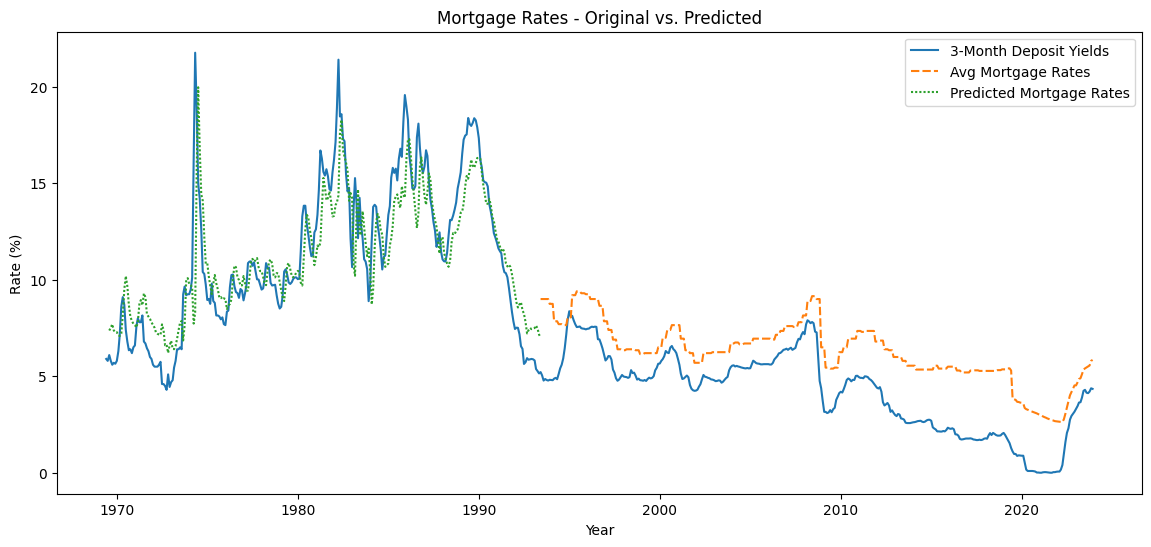

In [79]:
# Concatenate original and predicted mortgage rates
combined_data = pd.concat([interestRates['3-month BAB/Deposit Yields'], interestRates['avg mortgage'], predicted_mortgage_rates], axis=1)
combined_data.columns = ['3-Month Deposit Yields', 'Avg Mortgage Rates', 'Predicted Mortgage Rates']

# Plot the data
plt.figure(figsize=(14, 6))
sns.lineplot(data=combined_data)
plt.xlabel('Year')
plt.ylabel('Rate (%)')
plt.title('Mortgage Rates - Original vs. Predicted')
plt.ticklabel_format(style='plain', axis='y')
plt.show()

In [80]:
(interestRates['avg mortgage'] - interestRates['3-month BAB/Deposit Yields']).mean()

2.1059945504087194

In [81]:
predicted_mortgage_rates = predicted_mortgage_rates + 2.1059945504087194

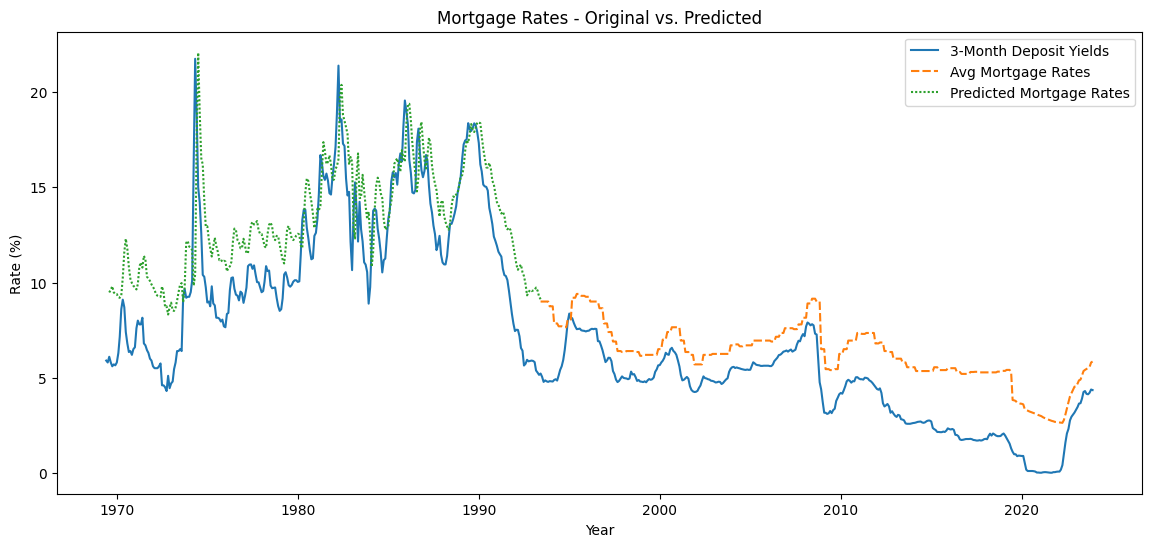

In [82]:
# Concatenate original and predicted mortgage rates
combined_data = pd.concat([interestRates['3-month BAB/Deposit Yields'], interestRates['avg mortgage'], predicted_mortgage_rates], axis=1)
combined_data.columns = ['3-Month Deposit Yields', 'Avg Mortgage Rates', 'Predicted Mortgage Rates']

# Plot the data
plt.figure(figsize=(14, 6))
sns.lineplot(data=combined_data)
plt.xlabel('Year')
plt.ylabel('Rate (%)')
plt.title('Mortgage Rates - Original vs. Predicted')
plt.ticklabel_format(style='plain', axis='y')
plt.show()

In [83]:
len(predicted_mortgage_rates)

289

In [84]:
interestRates.iloc[0:289, 4] = predicted_mortgage_rates

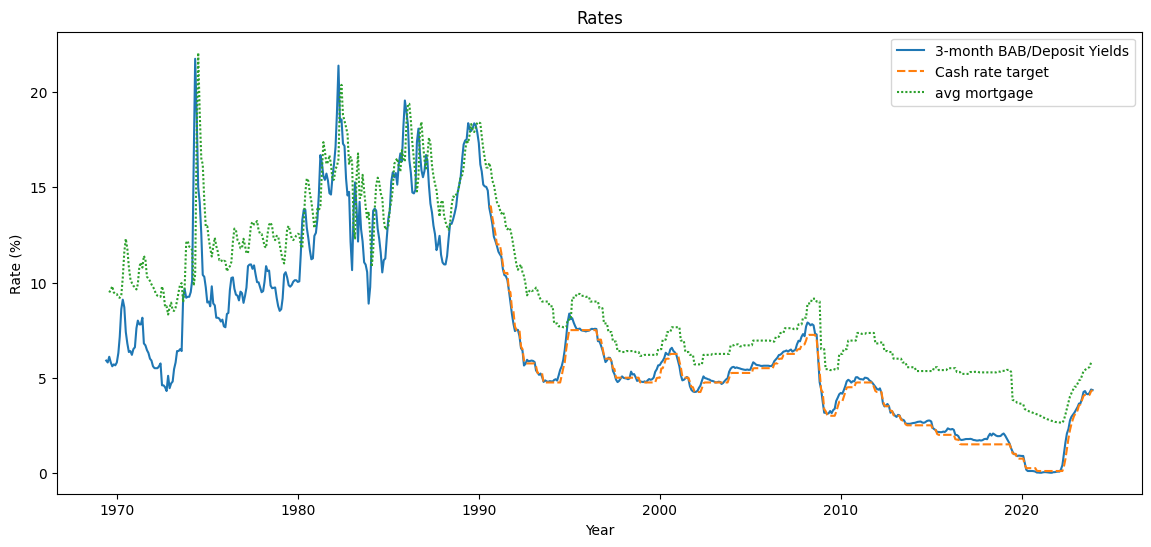

In [85]:
plt.figure(figsize = (14,6))
ax = sns.lineplot(data=interestRates.iloc[0:,[0,1,4]])
plt.xlabel('Year')
plt.ylabel('Rate (%)')
plt.title('Rates')
plt.ticklabel_format(style='plain', axis='y')

In [86]:
interestRates = interestRates/100

In [87]:
interestRates

,3-month BAB/Deposit Yields,Cash rate target,Mortgage rates,mortgage fund,avg mortgage
Date,,,,,
1969-06-01,0.0590,NaN,NaN,NaN,NaN
1969-07-01,0.0580,NaN,NaN,NaN,NaN
1969-08-01,0.0610,NaN,NaN,NaN,0.094765
1969-09-01,0.0580,NaN,NaN,NaN,0.096214
1969-10-01,0.0560,NaN,NaN,NaN,0.098016
...,...,...,...,...,...
2023-08-01,0.0415,0.0410,0.0546,NaN,0.054600
2023-09-01,0.0413,0.0410,0.0551,NaN,0.055100
2023-10-01,0.0421,0.0410,0.0556,NaN,0.055600


### Need to convert to effective monthly rate

(1+i)^(1/12)-1

In [88]:
interestRates['emr'] = (1+interestRates['avg mortgage'])**(1/12)-1

In [89]:
interestRates['emr_deposit'] = (1+interestRates['3-month BAB/Deposit Yields'])**(1/12)-1

$\huge
n = \frac {log(\frac{1}{-(\frac{PV \times i}{CF}-1)})}{log(1+i)}
$
##### where n = months, PV = present value, i = mortgage rate per month, CF = median monthly income

<Axes: xlabel='Date'>

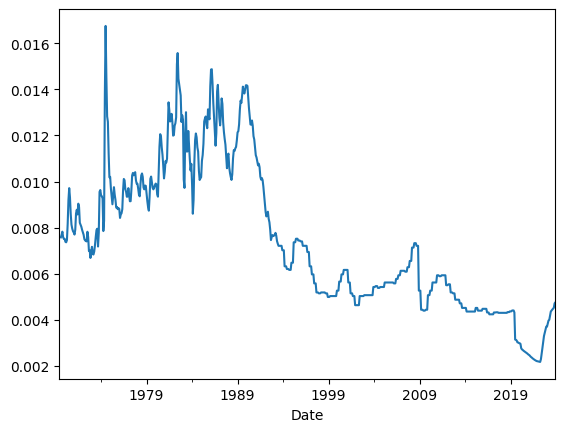

In [90]:
interestRates['emr'].plot()

In [91]:
interestRates

,3-month BAB/Deposit Yields,Cash rate target,Mortgage rates,mortgage fund,avg mortgage,emr,emr_deposit
Date,,,,,,,
1969-06-01,0.0590,NaN,NaN,NaN,NaN,NaN,0.004789
1969-07-01,0.0580,NaN,NaN,NaN,NaN,NaN,0.004709
1969-08-01,0.0610,NaN,NaN,NaN,0.094765,0.007573,0.004947
1969-09-01,0.0580,NaN,NaN,NaN,0.096214,0.007685,0.004709
1969-10-01,0.0560,NaN,NaN,NaN,0.098016,0.007823,0.004551
...,...,...,...,...,...,...,...
2023-08-01,0.0415,0.0410,0.0546,NaN,0.054600,0.004440,0.003394
2023-09-01,0.0413,0.0410,0.0551,NaN,0.055100,0.004480,0.003378
2023-10-01,0.0421,0.0410,0.0556,NaN,0.055600,0.004519,0.003442


### convert to average emr across the whole year

In [92]:
yearlyRatesEMR = pd.DataFrame()

In [93]:
yearlyRatesEMR['3m'] = interestRates['emr_deposit'].groupby(interestRates['emr_deposit'].index.year).mean()

In [94]:
yearlyRatesEMR['mr'] = interestRates['emr'].groupby(interestRates['emr'].index.year).mean()

### Saving interest rates

In [95]:
# Create an ExcelWriter object
excel_writer = pd.ExcelWriter('interestRates.xlsx', engine='xlsxwriter')

# Write each DataFrame to a separate worksheet
interestRates.to_excel(excel_writer, sheet_name='monthly')
yearlyRatesEMR.to_excel(excel_writer, sheet_name='yearly avg emr')

# Add more DataFrames as necessary

# Close the Pandas Excel writer and output the Excel file
excel_writer.close()

# Incomes
We don't have public data on income in capital cities. But we do have for states, full time earnings. Let's just assume no taxes on the state incomes is about equivilent to the capital city incomes. HILDA data does have capital city incomes from 2002 but they are not public. May look into this in a further version. Canberra is the only one likely to be correct as per usual so maybe we should apply a tax to them. But the average tax rate changes over time so I'm not sure what to do?

In [96]:
#https://www.abs.gov.au/statistics/labour/earnings-and-working-conditions/employee-earnings/latest-release#data-downloads
#Table 1 - Employee earnings, 1975-2022 -> Not capital cities... But it's the best we have got.
#Again because ABS excel files are strangely formatted I did some edits on Excel 

In [97]:
MIM = pd.read_csv('data/MedianIncomes.csv')
MIM = MIM.set_index(MIM['Date']).astype(float)
MIM = MIM.drop('Date', axis = 1)
MIF = pd.read_csv('data/MedianIncomesFemales.csv')
MIF = MIF.set_index(MIF['Date']).astype(float)
MIF = MIF.drop('Date', axis = 1)

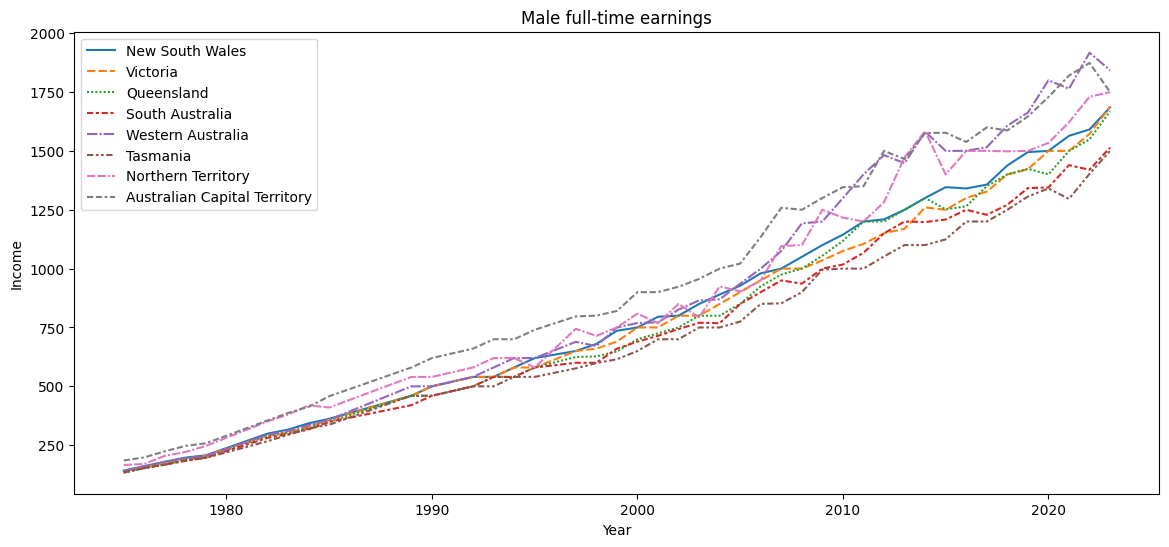

In [98]:
plt.figure(figsize = (14,6))
ax = sns.lineplot(data=MIM)
plt.xlabel('Year')
plt.ylabel('Income')
plt.title('Male full-time earnings')
plt.ticklabel_format(style='plain', axis='y')

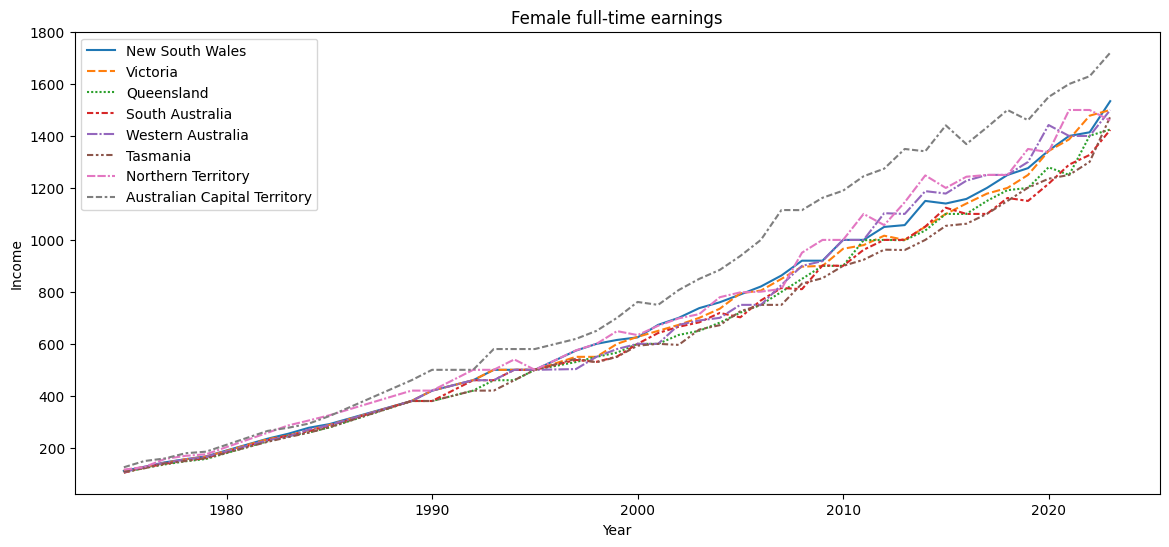

In [99]:
plt.figure(figsize = (14,6))
ax = sns.lineplot(data=MIF)
plt.xlabel('Year')
plt.ylabel('Income')
plt.title('Female full-time earnings')
plt.ticklabel_format(style='plain', axis='y')

In [100]:
#dealing with missing values via interpolation
for col in MIM.columns:
    MIM[col] = MIM[col].interpolate()
    MIF[col] = MIF[col].interpolate()

In [101]:
MIH = MIM + MIF

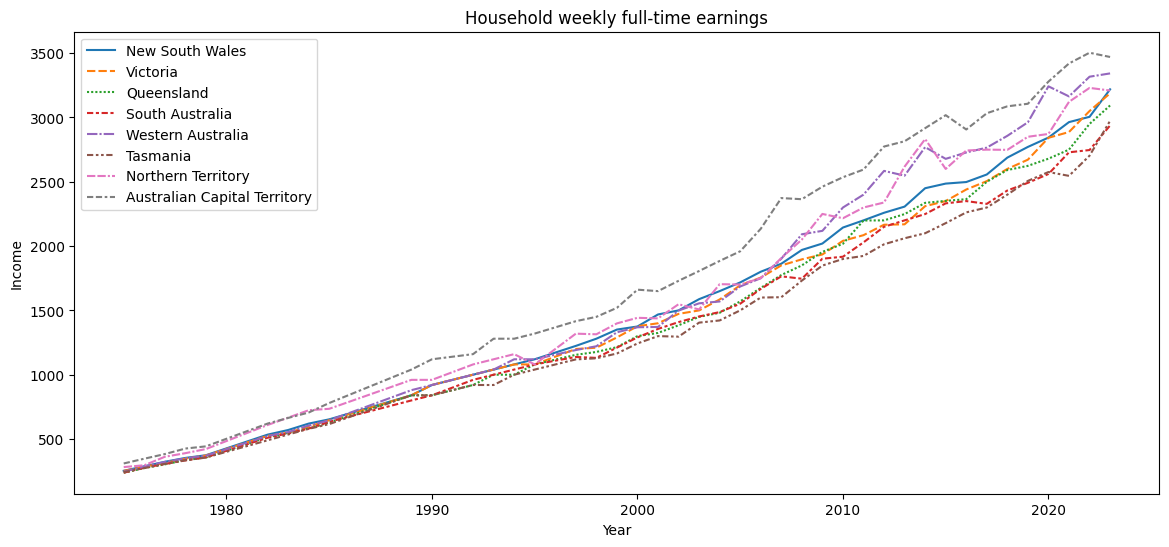

In [102]:
plt.figure(figsize = (14,6))
ax = sns.lineplot(data=MIH)
plt.xlabel('Year')
plt.ylabel('Income')
plt.title('Household weekly full-time earnings')
plt.ticklabel_format(style='plain', axis='y')

In [103]:
#working in months
MIH = MIH*4

# Formula for constant assumptions panels

*Use the future value version when saving up for deposit

$\huge
n = \frac {log(\frac{1}{-(\frac{PV \times i}{CF}-1)})}{log(1+i)}
$
##### where n = years, PV = present value, i = mortgage rate, CF = median yearly income

### convert to monthly

$\huge
n = \frac {log(\frac{1}{-(\frac{PV \times i}{CF}-1)})}{log(1+i)}
$
##### where n = months, PV = present value, i = mortgage rate per month, CF = median monthly income

### Apply Assumptions

$\huge
n = \frac {log(\frac{1}{-(\frac{PV \times i}{CF}-1)})}{log(1+i)}
$
##### where n = months, PV = price of property * 0.8, i = avg mortgage rate per month, CF = median monthly household income * 0.3

# Summary of data & Applying assumptions

In [104]:
prices = prices[5:]

In [105]:
yearlyRatesEMR = yearlyRatesEMR[6:]

In [106]:
loans = prices*1
deposit = prices*0.2
payments = MIH*0.27

# Calculations

In [107]:
#let's calc constant years if rates and incomes stayed same
constantyearsdeposit = prices*0 
constantyearsloan = prices*0 #create a database for years

## Fixed assumptions

### Deposit

In [108]:
cityindex = 0
row = 0
for city in constantyearsdeposit.columns:
    for i in constantyearsdeposit.index:
        try:
            #print(city, row)
            constantyearsdeposit.iloc[row, cityindex] = value = (math.log(deposit.iloc[row, cityindex]/payments.iloc[row, cityindex] * yearlyRatesEMR['3m'].iloc[row]+1) / math.log(1+yearlyRatesEMR['3m'].iloc[row]))/12
            #print(value)
            #print(i, cityindex)
        except ValueError as e:
            print("fail")
            #print(constantyears.iloc[row, cityindex])
            constantyearsdeposit.iloc[row, cityindex] = np.nan
        row += 1
    cityindex += 1
    row = 0

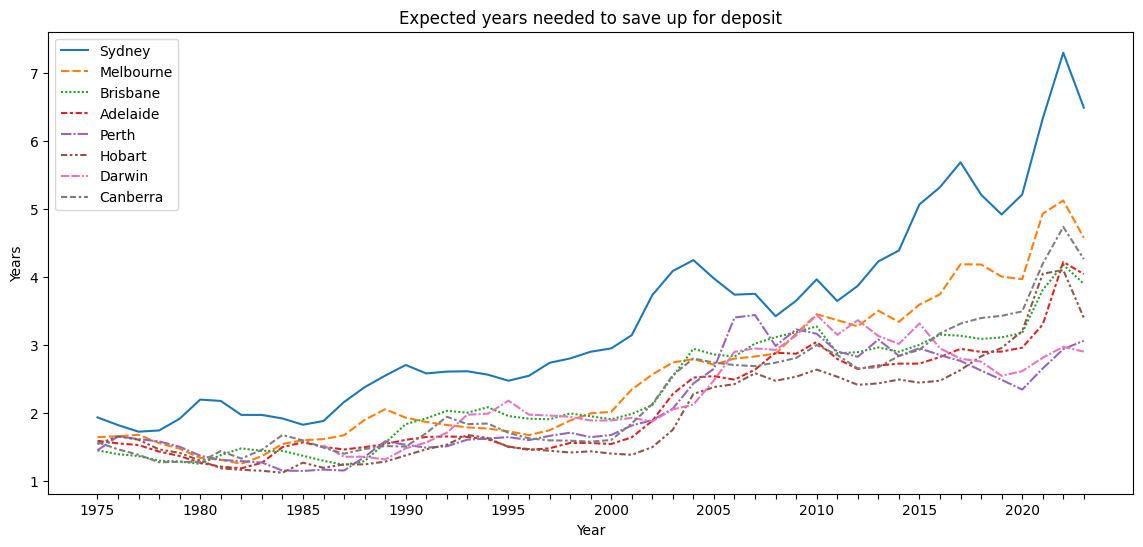

In [109]:
plt.figure(figsize = (14,6))
ax = sns.lineplot(data=constantyearsdeposit)
plt.xlabel('Year')
plt.ylabel('Years')
plt.title('Expected years needed to save up for deposit')
#plt.xticks(ticks=constantyears.index) 
plt.xticks(ticks=constantyearsdeposit.index, labels=['' if i % 5 != 0 else constantyearsdeposit.index[i] for i in range(len(constantyearsdeposit.index))])
plt.ticklabel_format(style='plain', axis='y')

### Mortgage

In [110]:
cityindex = 0
row = 0
for city in constantyearsloan.columns:
    for i in constantyearsloan.index:
        try:
            #print(city, row)
            constantyearsloan.iloc[row, cityindex] = value = (math.log(1/-((loans.iloc[row, cityindex]*yearlyRatesEMR['mr'].iloc[row]/payments.iloc[row, cityindex])-1)) / math.log(1+yearlyRatesEMR['mr'].iloc[row]))/12
            #print(value)
            #print(i, cityindex)
        except ValueError as e:
            #print("fail")
            #print(constantyears.iloc[row, cityindex])
            constantyearsloan.iloc[row, cityindex] = np.nan
        row += 1
    cityindex += 1
    row = 0

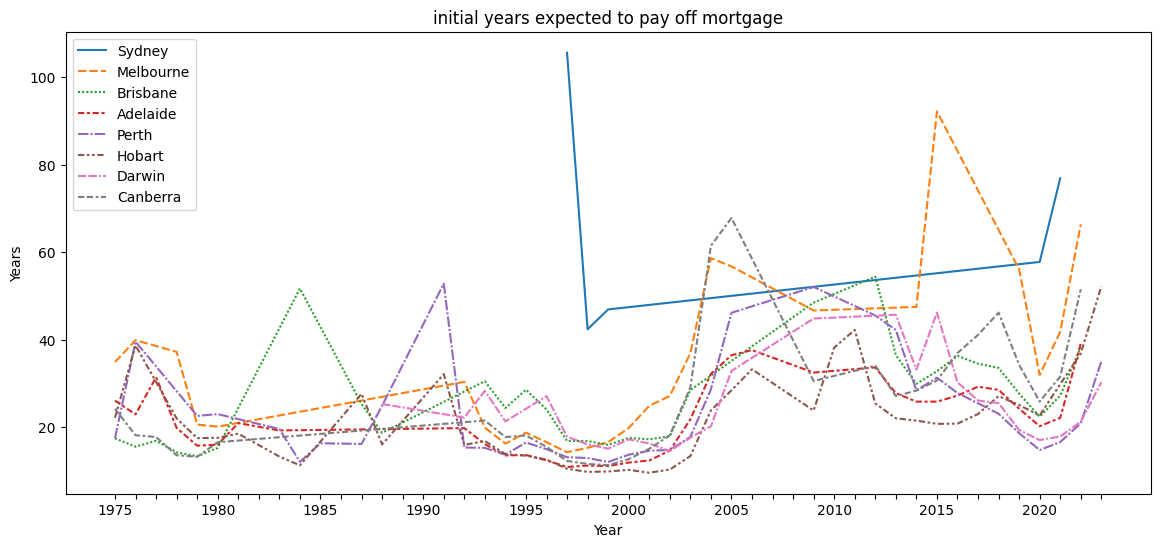

In [111]:
plt.figure(figsize = (14,6))
ax = sns.lineplot(data=constantyearsloan)
plt.xlabel('Year')
plt.ylabel('Years')
plt.title('initial years expected to pay off mortgage')
#plt.xticks(ticks=constantyears.index) 
plt.xticks(ticks=constantyearsloan.index, labels=['' if i % 5 != 0 else constantyearsloan.index[i] for i in range(len(constantyearsloan.index))])
plt.ticklabel_format(style='plain', axis='y')

### Total years

In [112]:
constyears = constantyearsdeposit + constantyearsloan

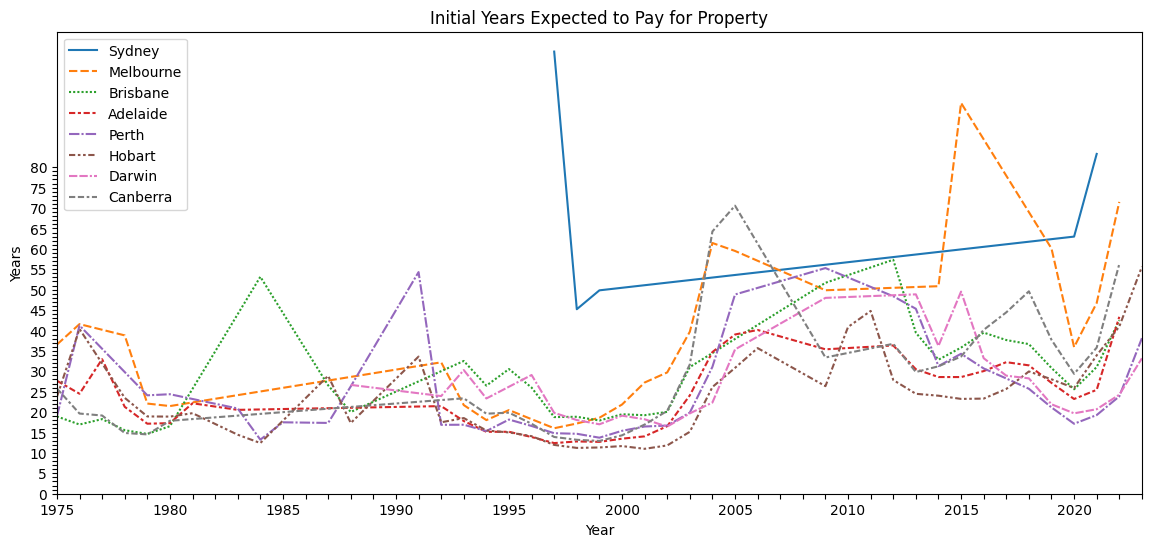

In [113]:
plt.figure(figsize=(14, 6))
ax = sns.lineplot(data=constyears)
plt.xlabel('Year')
plt.ylabel('Years')
plt.title('Initial Years Expected to Pay for Property')

# Set x-axis tick marks
plt.xticks(ticks=constyears.index, labels=['' if i % 5 != 0 else constyears.index[i] for i in range(len(constyears.index))])

# Set y-axis tick marks
plt.locator_params(axis='y', nbins=51)  # Set the number of ticks for y-axis
plt.yticks(ticks=range(81), labels=['' if i % 5 != 0 else i for i in range(81)])

plt.xlim(constyears.index.min(), constyears.index.max())  # Set x-axis limits to the minimum and maximum index values

plt.show()

## Allowing interest rates and income to vary

In [114]:
#let's calc constant years if rates and incomes stayed same
variedyearsdeposit = prices*0 
variedyearsloan = prices*0 #create a database for years

### Deposit

In [115]:
#iterate through the columns
col = 0
for i in variedyearsdeposit.columns:
    #iterate through the rows
    row = 0
    for j in variedyearsdeposit.index:
        savings = 0
        goal = deposit.iloc[row, col]
        #print("-----------------------------------")
        #print("city:", years.columns[col])
        #print("loan starting amount:", loan)
        months = 0
        year = 0
        while savings < goal and (row + year) < len(variedyearsdeposit):
            savings = (savings + payments.iloc[row+year, col])*(1+yearlyRatesEMR['3m'].iloc[row+year]) 
            #print("bal: ", savings)
            months += 1
            if (months == 12):
                year += 1
                months = 0
                
        if savings < goal:
            totalYears = np.nan

        if savings >= goal:
            variedyearsdeposit.iloc[row,col] = year
        year = 0
        row += 1
    col += 1

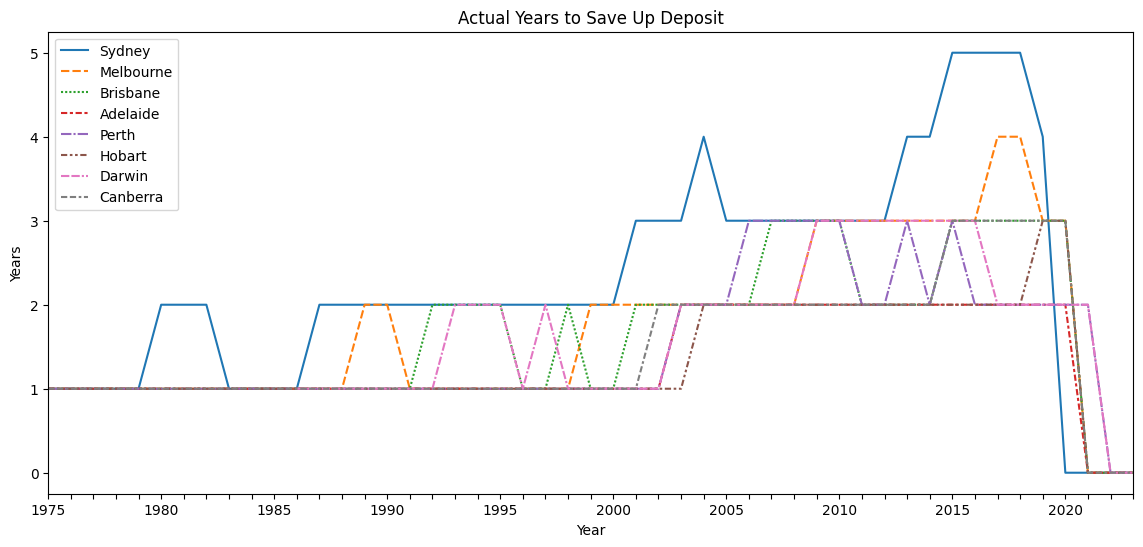

In [116]:
plt.figure(figsize=(14, 6))
ax = sns.lineplot(data=variedyearsdeposit)
plt.xlabel('Year')
plt.ylabel('Years')
plt.title('Actual Years to Save Up Deposit')

# Set x-axis tick marks
plt.xticks(ticks=constyears.index, labels=['' if i % 5 != 0 else constyears.index[i] for i in range(len(constyears.index))])

plt.xlim(constyears.index.min(), constyears.index.max())  # Set x-axis limits to the minimum and maximum index values

plt.show()

### Mortgage

In [117]:
#iterate through the columns
col = 0
for i in variedyearsloan.columns:
    #iterate through the rows
    row = 0
    for j in variedyearsloan.index:
        loan = loans.iloc[row, col]
        
        #print("-----------------------------------")
        #print("city:", years.columns[col])
        #print("loan starting amount:", loan)
        months = 0
        year = 0
        while loan > 0 and (row + year) < len(variedyearsloan):
            loan = (loan - payments.iloc[row+year, col])*(1+yearlyRatesEMR['mr'].iloc[row+year]) 
            #print("bal: ", savings)
            months += 1
            if (months == 12):
                year += 1
                months = 0
                
        if loan > 0:
            totalYears = np.nan

        if loan <= 0:
            variedyearsloan.iloc[row,col] = year
        year = 0
        row += 1
    col += 1

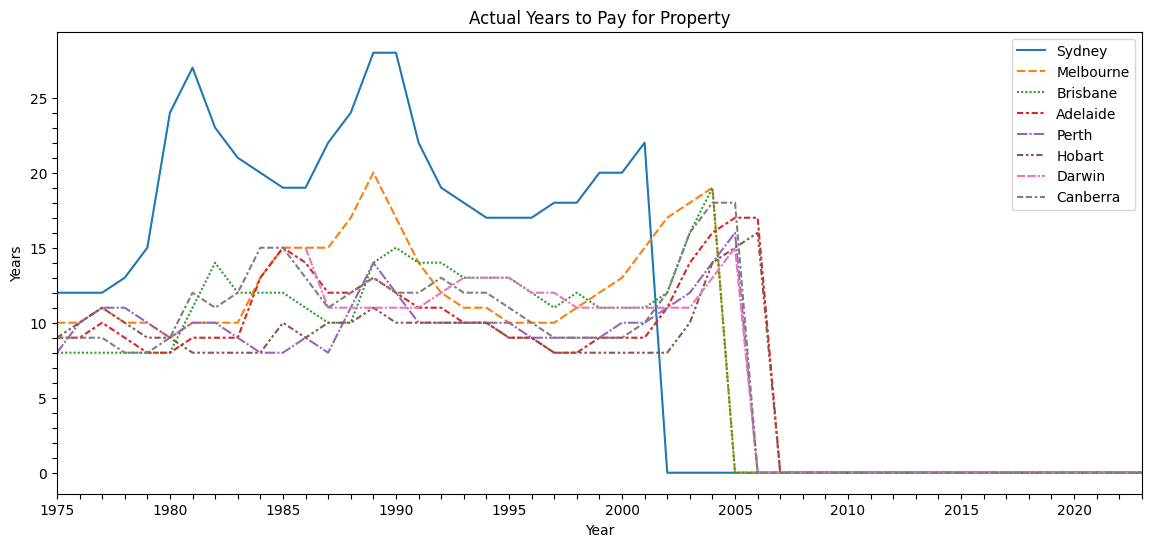

In [118]:
plt.figure(figsize=(14, 6))
ax = sns.lineplot(data=variedyearsloan)
plt.xlabel('Year')
plt.ylabel('Years')
plt.title('Actual Years to Pay for Property')

# Set x-axis tick marks
plt.xticks(ticks=constyears.index, labels=['' if i % 5 != 0 else constyears.index[i] for i in range(len(constyears.index))])

# Set y-axis tick marks
plt.locator_params(axis='y', nbins=51)  # Set the number of ticks for y-axis
plt.yticks(ticks=range(26), labels=['' if i % 5 != 0 else i for i in range(26)])

plt.xlim(constyears.index.min(), constyears.index.max())  # Set x-axis limits to the minimum and maximum index values

plt.show()

In [119]:
variedyears = variedyearsdeposit + variedyearsloan

In [120]:
variedyears2 = variedyears

In [121]:
variedyears2[variedyearsloan == 0] = np.nan 

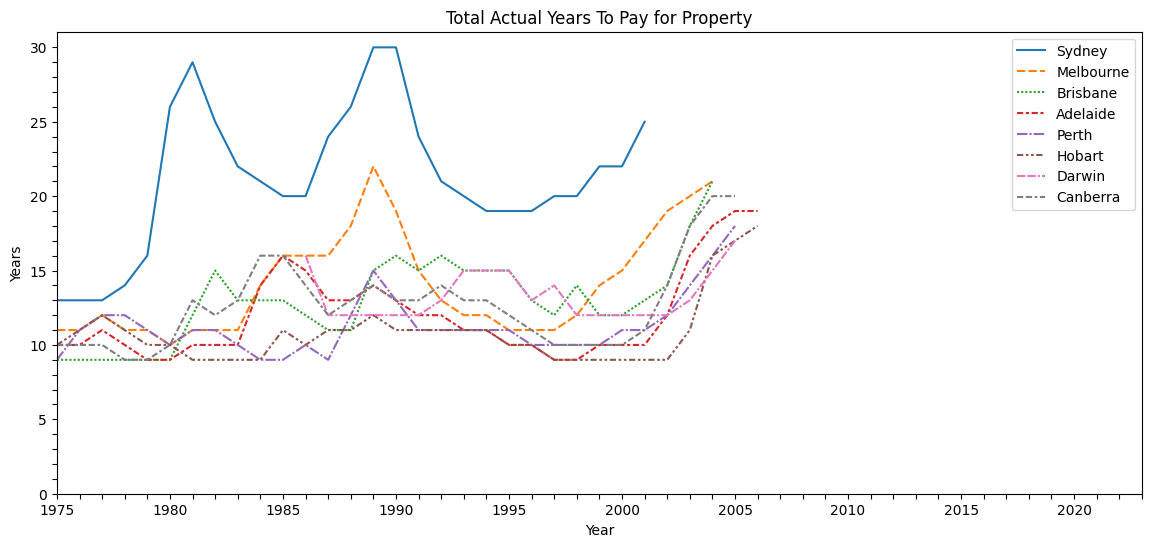

In [123]:
plt.figure(figsize=(14, 6))
ax = sns.lineplot(data=variedyears2)
plt.xlabel('Year')
plt.ylabel('Years')
plt.title('Total Actual Years To Pay for Property')

# Set x-axis tick marks
plt.xticks(ticks=constyears.index, labels=['' if i % 5 != 0 else constyears.index[i] for i in range(len(constyears.index))])

# Set y-axis tick marks
plt.locator_params(axis='y', nbins=31)  # Set the number of ticks for y-axis
plt.yticks(ticks=range(31), labels=['' if i % 5 != 0 else i for i in range(31)])

plt.xlim(constyears.index.min(), constyears.index.max())  # Set x-axis limits to the minimum and maximum index values

plt.show()

# has the difference changed over time?

In [ ]:
dif = constyears - variedyears2

In [ ]:
dif[variedyears2 == 0] = np.nan

In [ ]:
plt.figure(figsize=(14, 6))
ax = sns.lineplot(data=dif)
plt.xlabel('Year')
plt.ylabel('Years')
plt.title('Difference between what they signed up for and what they actually got')

# Set x-axis tick marks
plt.xticks(ticks=constyears.index, labels=['' if i % 5 != 0 else constyears.index[i] for i in range(len(constyears.index))])

# Set y-axis tick marks
plt.locator_params(axis='y', nbins=51)  # Set the number of ticks for y-axis
plt.yticks(ticks=range(11), labels=['' if i % 5 != 0 else i for i in range(11)])

plt.xlim(constyears.index.min(), constyears.index.max())  # Set x-axis limits to the minimum and maximum index values

plt.show()

## what about just mortgages

In [ ]:
dif = constantyearsloan - variedyearsloan

In [ ]:
dif[variedyearsloan == 0] = np.nan

In [ ]:
plt.figure(figsize=(14, 6))
ax = sns.lineplot(data=dif)
plt.xlabel('Year')
plt.ylabel('Years')
plt.title('Difference between what they signed up for and what they actually got')

# Set x-axis tick marks
plt.xticks(ticks=constyears.index, labels=['' if i % 5 != 0 else constyears.index[i] for i in range(len(constyears.index))])

# Set y-axis tick marks
plt.locator_params(axis='y', nbins=51)  # Set the number of ticks for y-axis
plt.yticks(ticks=range(11), labels=['' if i % 5 != 0 else i for i in range(11)])

plt.xlim(constyears.index.min(), constyears.index.max())  # Set x-axis limits to the minimum and maximum index values

plt.show()

In [ ]:
# maybe standardise it 

#Compare to other measures

# Ok... Forecasting incomes and interest rates into the future... The base case

### Backing interest rates out of yield curve

In [124]:
yieldCurve = pd.read_csv('data/yieldcurve.csv') #thanks to https://www.worldgovernmentbonds.com/country/australia/

In [125]:
yieldCurve

,Maturity,Last,Chg 1M,Chg 6M,Unnamed: 4,Last.1,Chg 1M.1,Chg 6M.1,Change
0,1 year,3.982%,-4.4 bp,-23.9 bp,NaN,96.17,0.04%,0.23%,25-Mar
1,2 years,3.716%,-6.7 bp,-36.8 bp,NaN,92.96,0.13%,0.70%,25-Mar
2,3 years,3.648%,-11.6 bp,-41.0 bp,NaN,89.81,0.34%,1.19%,25-Mar
3,4 years,3.658%,-11.8 bp,-41.9 bp,NaN,86.61,0.45%,1.62%,25-Mar
4,5 years,3.713%,-11.6 bp,-40.3 bp,NaN,83.34,0.57%,1.96%,25-Mar
5,6 years,3.787%,-12.8 bp,-40.1 bp,NaN,80.01,0.74%,2.34%,25-Mar
6,7 years,3.840%,-12.9 bp,-44.5 bp,NaN,76.82,0.88%,3.04%,25-Mar
7,8 years,3.954%,-13.4 bp,-39.6 bp,NaN,73.33,1.03%,3.09%,25-Mar
8,9 years,3.998%,-12.6 bp,-40.5 bp,NaN,70.27,1.09%,3.55%,25-Mar
9,10 years,4.031%,-12.1 bp,-39.1 bp,NaN,67.36,1.17%,3.82%,25-Mar


In [126]:
yieldCurve['Maturity'] = yieldCurve['Maturity'].str.split().str[0].astype(float)

In [127]:
yieldCurve['Last'] = yieldCurve['Last'].str[0:5].astype(float)/100

In [128]:
yields = yieldCurve.iloc[0:, 0:2]

In [156]:
# Create a linear interpolation function
interp_func = interp1d(yields['Maturity'], yields['Last'], kind='linear', fill_value='extrapolate')

# Define the range of new maturities for interpolation
new_maturities = [11.0, 13.0, 14.0, 16.0, 17.0, 18.0, 19.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27.0, 28.0, 29.0]

# Perform linear interpolation for the new maturities
interpolated_last = interp_func(new_maturities)

# Create a DataFrame for interpolated last values
interpolated_df = pd.DataFrame({'Maturity': new_maturities, 'Last': interpolated_last})

# Concatenate the original DataFrame with the interpolated DataFrame
combined_df = pd.concat([yields, interpolated_df], ignore_index=True)

# Sort the DataFrame by Maturity
combined_df = combined_df.sort_values(by='Maturity').reset_index(drop=True)

<Axes: >

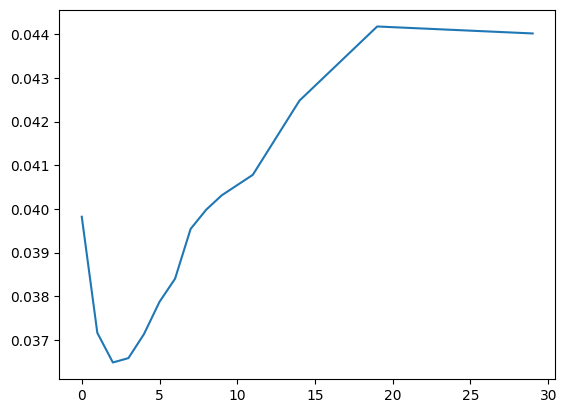

In [157]:
combined_df['Last'].plot()

<Axes: >

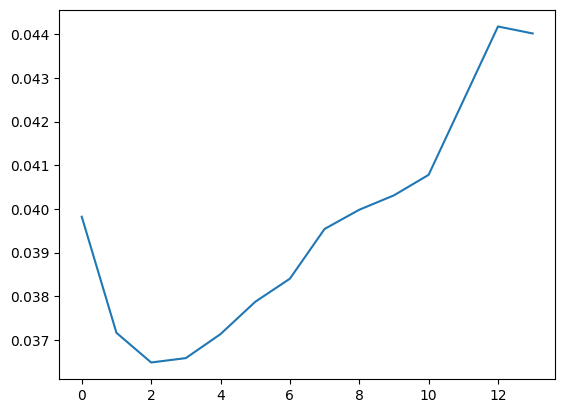

In [130]:
yieldCurve['Last'].plot()

In [131]:
yieldCurve = combined_df

In [132]:
index = []
rates = []
count = 0
for i in yieldCurve.index:
    #print("rate1:", yieldCurve['Maturity'][i])
    for j in yieldCurve.index:
        if j>i and j!=i and count < 1:
            #print(yieldCurve['Maturity'][j])
            index.append((str(yieldCurve['Maturity'][i]), str(yieldCurve['Maturity'][j])))
            rates.append( ((1+yieldCurve['Last'][j])**(yieldCurve['Maturity'][j])/(1+yieldCurve['Last'][i])**(yieldCurve['Maturity'][i]) )**(1/(yieldCurve['Maturity'][j]-yieldCurve['Maturity'][i]))-1)
            count += 1
    count = 0

In [133]:
forwardRates = pd.DataFrame({'Index': index, 'Rates': rates})

<Axes: >

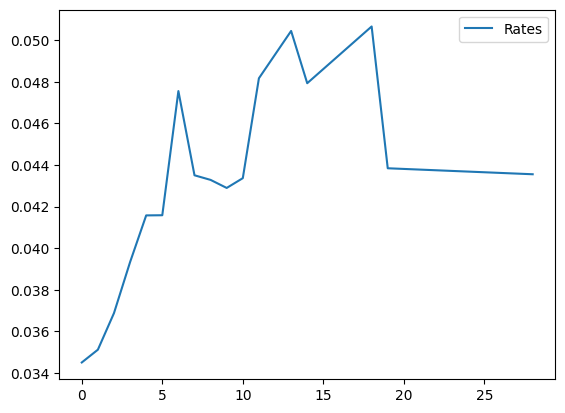

In [134]:
forwardRates.plot()

In [135]:
premium = 3.3645342070504625/100 #worked out before**

In [136]:
forwardRates['Deposit'] = forwardRates['Rates']

In [137]:
forwardRates['Rates'] = forwardRates['Rates'] + premium

In [138]:
forwardRates['Deposit'] = (1+forwardRates['Deposit'])**(1/12)-1

In [139]:
forwardRates['Rates'] = (1+forwardRates['Rates'])**(1/12)-1

<Axes: >

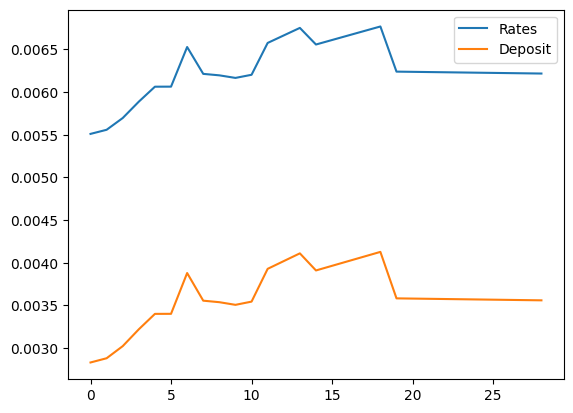

In [140]:
forwardRates.plot()

In [141]:
#save for the boys

In [142]:
forwardRates.to_csv('forwardRates.csv', index=False)

### Forecast incomes using five year rates

Look at Aus Treasury and NSW Treausury income growth
Maybe use a 10 year average

In [143]:
longGrowthRates = []
for state in MIH.columns:
    #print(state)
    avg = (1+(MIH[state].iloc[-1]-MIH[state].iloc[0])/MIH[state].iloc[0])**(1/49)-1
    longGrowthRates.append(avg)

In [144]:
fivYearGrowthRates = []
for state in MIH.columns:
    #print(state)
    avg = (1+(MIH[state].iloc[-1]-MIH[state].iloc[-5])/MIH[state].iloc[-5])**(1/5)-1
    fivYearGrowthRates.append(avg)

In [145]:
longGrowthRates

[0.05327764431906967,
 0.05315544491183344,
 0.05373496023594382,
 0.05262760534141808,
 0.05469226537482652,
 0.05244349067294385,
 0.05088520279717801,
 0.05053004163613517]

In [146]:
fivYearGrowthRates

[0.030411320261402475,
 0.03595071931595495,
 0.033451828929410565,
 0.03347121667127473,
 0.024429190122095656,
 0.03476471850515295,
 0.02405330459368371,
 0.02238950242971205]

### Estimating D9

In [148]:
variedyearsloanEst = variedyearsloan*0

In [ ]:
#now let's calculate how many years it may have taken if their interest rate and incomes changed, if a loan remains at 2023, we will take the forward interest rate from the yield curve
#but inflate wages by the five year growth rate for that state

In [ ]:
forwardRates['Rates'].iloc[4]

In [149]:
#iterate through the columns
col = 0
for i in variedyearsloanEst.columns:
    #iterate through the rows
    row = 0
    for j in variedyearsloan.index:
        loan = loans.iloc[row, col]
        
        #print("-----------------------------------")
        #print("city:", years.columns[col])
        #print("loan starting amount:", loan)
        months = 0
        year = 0
        while loan > 0 and (row + year) < len(variedyearsloan):
            loan = (loan - payments.iloc[row+year, col])*(1+yearlyRatesEMR['3m'].iloc[row+year]) 
            #print("bal: ", savings)
            months += 1
            if (months == 12):
                year += 1
                months = 0
                
        payment = payments.iloc[-1, col]  
        if loan > 0:
            #totalYears = np.nan
            multiplier = 1+fivYearGrowthRates[col]
            count = 0
            while loan > 0:
                #print("-----------------------------")
                #print("Year: ", 2024+year)
                #print("Place: ", variedyearsloanEst.columns[col])
                #print("loan bal: ", loan)
                
                payment = payment * multiplier

                try:
                    loan = (loan-payment)*(1+ forwardRates['Rates'].iloc[count])
                except:
                    loan = (loan-payment)*(1+ forwardRates['Rates'].iloc[-1])
                months += 1
                count += 1
                if (months == 12):
                    year += 1
                    months = 0

        if loan <= 0:
            variedyearsloanEst.iloc[row,col] = year
        year = 0
        row += 1
    col += 1

In [151]:
variedyearsloanEst2 = variedyearsloanEst

In [ ]:
variedyearsloanEst2[variedyears2.notna()] = np.nan

In [153]:
variedyearsdepositEst = variedyearsdeposit*0

In [154]:
#iterate through the columns
col = 0
for i in variedyearsdepositEst.columns:
    #iterate through the rows
    row = 0
    for j in variedyearsdeposit.index:
        savings = 0
        goal = deposit.iloc[row, col]
        #print("-----------------------------------")
        #print("city:", years.columns[col])
        #print("loan starting amount:", loan)
        months = 0
        year = 0
        while savings < goal and (row + year) < len(variedyearsdepositEst):
            savings = (savings + payments.iloc[row+year, col])*(1+yearlyRatesEMR['3m'].iloc[row+year]) 
            #print("bal: ", savings)
            months += 1
            if (months == 12):
                year += 1
                months = 0
                
        if savings < goal:
            #totalYears = np.nan
            multiplier = 1+fivYearGrowthRates[col]
            count = 0
            while savings < goal:
                #print("-----------------------------")
                #print("Year: ", 2024+year)
                #print("Place: ", variedyearsloanEst.columns[col])
                #print("loan bal: ", loan)
                
                payment = payment * multiplier

                try:
                    savings = (savings+payment)*(1+ forwardRates['Deposit'].iloc[count])
                except:
                    loan = (savings+payment)*(1+ forwardRates['Deposit'].iloc[-1])
                months += 1
                count += 1
                if (months == 12):
                    year += 1
                    months = 0


        if savings >= goal:
            variedyearsdepositEst.iloc[row,col] = year
        year = 0
        row += 1
    col += 1

In [ ]:
plt.figure(figsize=(14, 6))
ax = sns.lineplot(data=variedyearsloanEst)
plt.xlabel('Year')
plt.ylabel('Years')
plt.title('forecasted years with mortgage')

# Set x-axis tick marks
plt.xticks(ticks=constyears.index, labels=['' if i % 5 != 0 else constyears.index[i] for i in range(len(constyears.index))])

# Set y-axis tick marks
plt.locator_params(axis='y', nbins=51)  # Set the number of ticks for y-axis
plt.yticks(ticks=range(26), labels=['' if i % 5 != 0 else i for i in range(26)])

plt.xlim(constyears.index.min(), constyears.index.max())  # Set x-axis limits to the minimum and maximum index values

plt.show()

In [ ]:
plt.figure(figsize=(14, 6))
ax = sns.lineplot(data=variedyearsloanEst2)
plt.xlabel('Year')
plt.ylabel('Years')
plt.title('Forecast years with mortgage if a mortgage exists at 2023')

# Set x-axis tick marks
plt.xticks(ticks=constyears.index, labels=['' if i % 5 != 0 else constyears.index[i] for i in range(len(constyears.index))])

# Set y-axis tick marks
plt.locator_params(axis='y', nbins=51)  # Set the number of ticks for y-axis
plt.yticks(ticks=range(26), labels=['' if i % 5 != 0 else i for i in range(26)])

plt.xlim(constyears.index.min(), constyears.index.max())  # Set x-axis limits to the minimum and maximum index values

plt.show()

In [ ]:
plt.figure(figsize=(14, 6))
ax = sns.lineplot(data=variedyearsdepositEst)
plt.xlabel('Year')
plt.ylabel('Years')
plt.title('Forecast years to save up for deposit')

# Set x-axis tick marks
plt.xticks(ticks=constyears.index, labels=['' if i % 5 != 0 else constyears.index[i] for i in range(len(constyears.index))])

# Set y-axis tick marks
plt.locator_params(axis='y', nbins=51)  # Set the number of ticks for y-axis
plt.yticks(ticks=range(26), labels=['' if i % 5 != 0 else i for i in range(26)])

plt.xlim(constyears.index.min(), constyears.index.max())  # Set x-axis limits to the minimum and maximum index values

plt.show()

## Adding it to the deposits for the total estimate

In [ ]:
actual = variedyearsdepositEst + variedyearsloanEst

In [ ]:
deposits = actual - variedyearsloanEst

In [ ]:
plt.figure(figsize=(14, 6))
ax = sns.lineplot(data=actual)
plt.xlabel('Year')
plt.ylabel('Years')
plt.title('Forecast years to pay for property (deposit and mortgage)')

# Set x-axis tick marks
plt.xticks(ticks=constyears.index, labels=['' if i % 5 != 0 else constyears.index[i] for i in range(len(constyears.index))])

# Set y-axis tick marks
plt.locator_params(axis='y', nbins=51)  # Set the number of ticks for y-axis
plt.yticks(ticks=range(26), labels=['' if i % 5 != 0 else i for i in range(26)])

plt.xlim(constyears.index.min(), constyears.index.max())  # Set x-axis limits to the minimum and maximum index values

plt.show()

In [ ]:
actual.fillna(0, inplace=True)

In [ ]:
variedyears2.fillna(0, inplace=True)

In [ ]:
final = actual + variedyears2

In [ ]:
final[final == 0] = np.nan 

In [ ]:
plt.figure(figsize=(14, 6))
ax = sns.lineplot(data=final)
plt.xlabel('Year')
plt.ylabel('Years')
plt.title('Forecast years to pay for property (deposit and mortgage)')

# Set x-axis tick marks
plt.xticks(ticks=constyears.index, labels=['' if i % 5 != 0 else constyears.index[i] for i in range(len(constyears.index))])

# Set y-axis tick marks
plt.locator_params(axis='y', nbins=51)  # Set the number of ticks for y-axis
plt.yticks(ticks=range(26), labels=['' if i % 5 != 0 else i for i in range(26)])

plt.xlim(constyears.index.min(), constyears.index.max())  # Set x-axis limits to the minimum and maximum index values

plt.show()

In [ ]:
variedyearsdeposit.fillna(0, inplace=True)

In [ ]:
variedyearsdepositEst[variedyearsdeposit != 0] = np.nan 

In [ ]:
variedyearsdepositEst.fillna(0, inplace=True)

In [ ]:
deposits = variedyearsdepositEst + variedyearsdeposit

In [ ]:
plt.figure(figsize=(14, 6))
ax = sns.lineplot(data=deposits)
plt.xlabel('Year')
plt.ylabel('Years')
plt.title('Forecast years to pay for property (deposit and mortgage)')

# Set x-axis tick marks
plt.xticks(ticks=constyears.index, labels=['' if i % 5 != 0 else constyears.index[i] for i in range(len(constyears.index))])

# Set y-axis tick marks
plt.locator_params(axis='y', nbins=51)  # Set the number of ticks for y-axis
plt.yticks(ticks=range(26), labels=['' if i % 5 != 0 else i for i in range(26)])

plt.xlim(constyears.index.min(), constyears.index.max())  # Set x-axis limits to the minimum and maximum index values

plt.show()

In [ ]:
variedyearsloanEst.fillna(0, inplace=True)

In [ ]:
variedyearsloanEst[variedyearsloan != 0] = np.nan 

In [ ]:
variedyearsloanEst.fillna(0, inplace=True)

In [ ]:
loans = variedyearsloanEst + variedyearsloan

In [ ]:
plt.figure(figsize=(14, 6))
ax = sns.lineplot(data=loans)
plt.xlabel('Year')
plt.ylabel('Years')
plt.title('Forecast years to pay for property (deposit and mortgage)')

# Set x-axis tick marks
plt.xticks(ticks=constyears.index, labels=['' if i % 5 != 0 else constyears.index[i] for i in range(len(constyears.index))])

# Set y-axis tick marks
plt.locator_params(axis='y', nbins=51)  # Set the number of ticks for y-axis
plt.yticks(ticks=range(26), labels=['' if i % 5 != 0 else i for i in range(26)])

plt.xlim(constyears.index.min(), constyears.index.max())  # Set x-axis limits to the minimum and maximum index values

plt.show()

## Final Panels

variedyearsloanEst, variedyearsloan, variedyearsdeposit, variedyearsdepositEst

constantyearsdeposit, constantyearsloan

In [ ]:
#Save my work for the others
excel_writer = pd.ExcelWriter('affordabilityPanels.xlsx', engine='xlsxwriter')
# Write each panel to a separate worksheet
constantyearsdeposit.to_excel(excel_writer, sheet_name='deposit_constant')
constantyearsloan.to_excel(excel_writer, sheet_name='mortgage_constant')
variedyearsdeposit.to_excel(excel_writer, sheet_name='deposit_varied')
variedyearsloan.to_excel(excel_writer, sheet_name='mortgage_varied')
variedyearsdepositEst.to_excel(excel_writer, sheet_name='deposit_varied_estimates')
variedyearsloanEst.to_excel(excel_writer, sheet_name='mortgage_varied_estimates')

# Add more panels as necessary
# Close the Pandas Excel writer and output the Excel file
excel_writer.close()

# Plots for Slides

# Constant inputs total years

In [ ]:
test = constyears.replace(np.nan, np.inf)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Plotting with Matplotlib
plt.figure(figsize=(14, 6))
plt.plot(test)

plt.xlabel('Year')
plt.ylabel('Years')

# Set x-axis tick marks
plt.xticks(ticks=constyears.index, labels=['' if i % 5 != 0 else constyears.index[i] for i in range(len(constyears.index))])

# Set y-axis tick marks
plt.locator_params(axis='y', nbins=51)
plt.yticks(ticks=range(66), labels=['' if i % 5 != 0 else i for i in range(66)])

plt.xlim(constyears.index.min(), constyears.index.max())
plt.ylim(0, 65)  # Limit y-axis from 0 to 65

# Add vertical lines if the current value is np.inf and the last observation is not np.inf
for column in test.columns:
    for idx in range(1, len(test)):
        current_value = test[column].iloc[idx]
        last_observation = test[column].iloc[idx - 1]

        if np.isinf(current_value) and not np.isinf(last_observation):
            x_pos = test.index[idx]  # X position of the line
            y_pos = last_observation  # Y position of the line
            plt.axvline(x=x_pos-1, ymin=(y_pos-4) / 65, ymax=(y_pos + 4) / 65, color='gray', linestyle='-', marker='', linewidth=1)  # Draw the vertical line
    
    for idx in range(1, len(test)-1):
        current_value = test[column].iloc[idx]
        next_observation = test[column].iloc[idx + 1]
            
        if np.isinf(current_value) and not np.isinf(next_observation):
            x_pos = test.index[idx]  # X position of the line
            y_pos = next_observation  # Y position of the line
            plt.axvline(x=x_pos+1, ymin=(y_pos-4) / 65, ymax=(y_pos + 4) / 65, color='gray', linestyle='-', marker='', linewidth=1)  # Draw the vertical line



plt.legend(test.columns, loc='best', framealpha=0)

plt.savefig('constant_inputs_total_years.png', transparent=True, bbox_inches='tight', facecolor='none')
plt.show()

## Varied inputs total years

In [ ]:
actual + variedyears2

In [ ]:
plt.figure(figsize=(14, 6))
ax = sns.lineplot(data=variedyears2.replace(0,np.nan), linestyle='solid', marker='', dashes=False, legend=True)
ax = sns.lineplot(data=actual.replace(0,np.nan), marker='', color='blue', legend=False)

count = 0
for line in plt.gca().lines:
    if count > 7:
        line.set_linestyle('--')
    count += 1

# Adding vertical lines for forecast start years
forecasts_start = {
    'Sydney': 2003,
    'Melbourne': 2009,
    'Brisbane': 2008,
    'Adelaide': 2010,
    'Perth': 2007,
    'Hobart': 2013,
    'Darwin': 2009,
    'Canberra': 2010
}

# Y coordinates for each city
city_y_coords = {
    'Sydney': 22,
    'Melbourne': 16,
    'Brisbane': 17.0,
    'Adelaide': 15.0,
    'Perth': 18.0,
    'Hobart': 11.0,
    'Darwin': 16.0,
    'Canberra': 15.0
}

# Y coordinates for each city
city_y_coords2 = {
    'Sydney': 24,
    'Melbourne': 17,
    'Brisbane': 19,
    'Adelaide': 16,
    'Perth': 20,
    'Hobart': 13,
    'Darwin': 17,
    'Canberra': 16
}

# Adding vertical lines for each city's forecast start year at the respective y-position
for city, year in forecasts_start.items():
    plt.axvline(x=year-1, ymin=(city_y_coords2[city] - 1) / 25, ymax=(city_y_coords2[city] + 1) / 25, linestyle='-', color='grey', linewidth=1)
    plt.axvline(x=year, ymin=(city_y_coords[city] - 1) / 25, ymax=(city_y_coords[city] + 1) / 25, linestyle='-', color='grey', linewidth=1)


plt.xlabel('Year')
plt.ylabel('Years')

#plt.title('Forecast years to pay for property (deposit and mortgage)')

# Set x-axis tick marks
plt.xticks(ticks=constyears.index, labels=['' if i % 5 != 0 else constyears.index[i] for i in range(len(constyears.index))])

# Set y-axis tick marks
plt.locator_params(axis='y', nbins=51)  # Set the number of ticks for y-axis
plt.yticks(ticks=range(26), labels=['' if i % 5 != 0 else i for i in range(26)])

plt.xlim(constyears.index.min(), constyears.index.max())  # Set x-axis limits to the minimum and maximum index values

plt.legend(loc='best', framealpha=0)

plt.savefig('varied inputs total years', transparent=True, bbox_inches='tight', facecolor='none')
plt.show()

# The Sydney Case - A comparison

### Price to Income ratio, initial years, actual years

In [ ]:
pti = prices*0

In [ ]:
prices.index = MIH.index

In [ ]:
MIH.columns = prices.columns

In [ ]:
MIH = MIH*12

In [ ]:
ptir = prices.div(MIH)

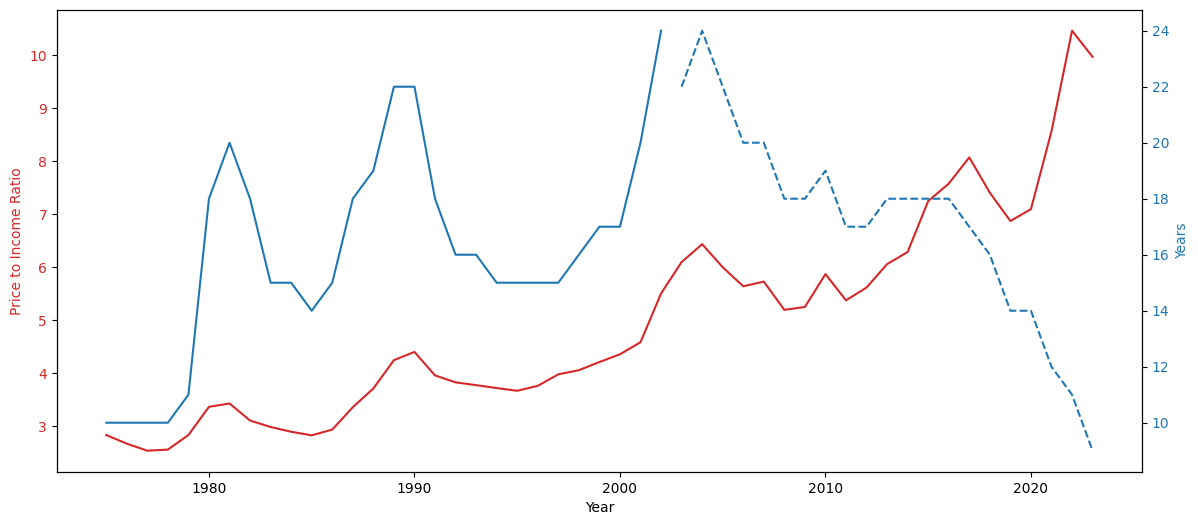

In [448]:
# Plot ptir['Sydney']
fig, ax1 = plt.subplots(figsize=(14, 6))
color = 'tab:red'
ax1.set_xlabel('Year')
ax1.set_ylabel('Price to Income Ratio', color=color)
ax1.plot(ptir['Sydney'], color=color)
ax1.tick_params(axis='y', labelcolor=color)

# Create a secondary y-axis for variedyears2['Sydney']
ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('Years', color=color)
ax2.plot(variedyears2['Sydney'].replace(0, np.nan), color=color)
ax2.plot(actual['Sydney'].replace(0, np.nan), color=color, linestyle='--')
ax2.tick_params(axis='y', labelcolor=color)

#plt.title('Price to Income Ratio vs. Years to Pay for a Property in Sydney')
plt.savefig('comparison', transparent=True, bbox_inches='tight', facecolor='none')
plt.show()